In [1]:
import os
import textwrap

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from datasets import load_dataset

In [2]:
# Load our data
domain_worker_metadata_df = load_dataset("SALT-NLP/WORKBank", data_files="worker_data/domain_worker_metadata.csv")['train'].to_pandas()

# Load and clean BLS wage data
bls_occupation_data = pd.read_csv("../external_data/M2024_bls_wage_data.csv")[['OCC_TITLE', 'TOT_EMP']]
bls_occupation_data["TOT_EMP"] = bls_occupation_data["TOT_EMP"].str.replace(',', '').astype(int)

# Read BLS data on detailed occupation demographics
age_bls = pd.read_csv("../external_data/bls_age.csv")
race_gender_bls = pd.read_csv("../external_data/bls_race_gender.csv")

## Demographic Diversity

In [3]:
# Get list of shared occupations across WORKBank and BLS
workbank_occupations = domain_worker_metadata_df["Occupation (O*NET-SOC Title)"].unique()
bls_occupations = bls_occupation_data["OCC_TITLE"].unique()
shared_occupations = list(set(workbank_occupations).intersection(set(bls_occupations)))
shared_occupations.sort()

# Filter both datasets to shared occupations
workbank_filtered = domain_worker_metadata_df[
    domain_worker_metadata_df["Occupation (O*NET-SOC Title)"].isin(shared_occupations)
]
bls_filtered = bls_occupation_data[
    bls_occupation_data["OCC_TITLE"].isin(shared_occupations)
]

## View Occupation Distribution of WORKBank vs. BLS (for covered occupations)

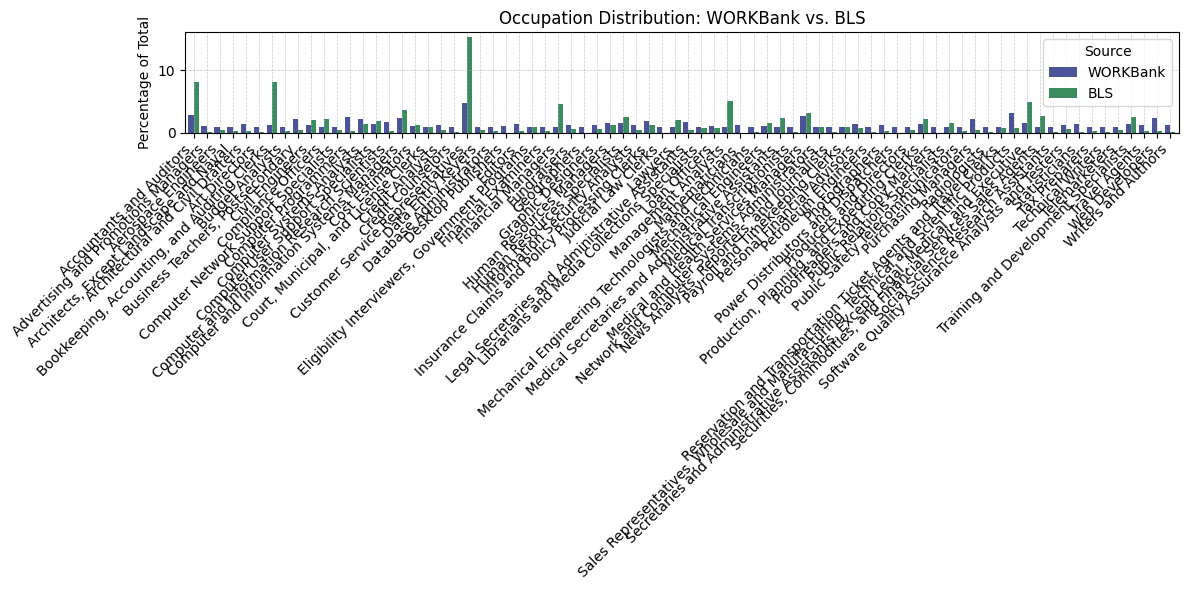

In [4]:
# Calculate counts for each occupation in WORKBank
workbank_counts = workbank_filtered["Occupation (O*NET-SOC Title)"].value_counts()
workbank_percent = (workbank_counts / workbank_counts.sum()) * 100

# Ccalculate percentages for BLS occupation distribution
bls_grouped = bls_filtered.groupby("OCC_TITLE")["TOT_EMP"].sum()
bls_percent = (bls_grouped / bls_grouped.sum()) * 100

# Align both series on shared occupations for consistent x-axis
combined_df = pd.DataFrame({
    "WORKBank": workbank_percent,
    "BLS": bls_percent
}).dropna()

# Plot
ax = combined_df.plot(kind="bar", figsize=(12, 6), width=0.8, color=["#4a5496", "#3c8c61"])

ax.grid(True, ls="--", lw=.5, alpha=.7)
plt.ylabel("Percentage of Total")
plt.title("Occupation Distribution: WORKBank vs. BLS")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title="Source")
plt.show()


## View Sector Distribution of WORKBank vs. US Workforce

In [5]:
# Path to the folder containing the sector files
sector_folder_path = "../external_data/onet_data/onet_sector"

# Dictionary to hold the mapping
occupation_to_sector = {}

# Loop through each CSV file in the folder
for filename in os.listdir(sector_folder_path):
    if filename.endswith(".csv"):
        sector_name = filename.replace(".csv", "").replace("_", " ")
        file_path = os.path.join(sector_folder_path, filename)

        # Read the CSV and extract occupations
        df = pd.read_csv(file_path)
        if "Occupation" in df.columns:
            for occupation in df["Occupation"].dropna():
                occupation_to_sector[occupation.strip()] = sector_name

In [6]:
# Assign sector using occupation-to-sector mapping
domain_worker_metadata_df["Sector"] = domain_worker_metadata_df["Occupation (O*NET-SOC Title)"].map(occupation_to_sector)

# WORKBank: count by sector and normalize
workbank_sector_counts = (
    domain_worker_metadata_df["Sector"].value_counts(normalize=True) * 100
).reset_index()
workbank_sector_counts.columns = ["Sector", "WORKBank"]

# BLS: sum employment by sector, then normalize
bls_occupation_data["Sector"] = bls_occupation_data["OCC_TITLE"].map(occupation_to_sector)
bls_all_sector_counts = bls_occupation_data.groupby("Sector")["TOT_EMP"].sum()
bls_all_sector_percentages = (
    (bls_all_sector_counts / bls_all_sector_counts.sum()) * 100
).reset_index()
bls_all_sector_percentages.columns = ["Sector", "BLS"]

# Merge BLS with WORKBank data on Sector
merged_all_sectors = bls_all_sector_percentages.merge(workbank_sector_counts, on="Sector", how="left").set_index("Sector").fillna(0)

## Compare sector distribution with BLS data

/var/folders/l4/hnclc8y56gxb79lptyr0msl80000gn/T/ipykernel_45599/4136950128.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_filtered["Sector"] = bls_filtered["OCC_TITLE"].map(occupation_to_sector)


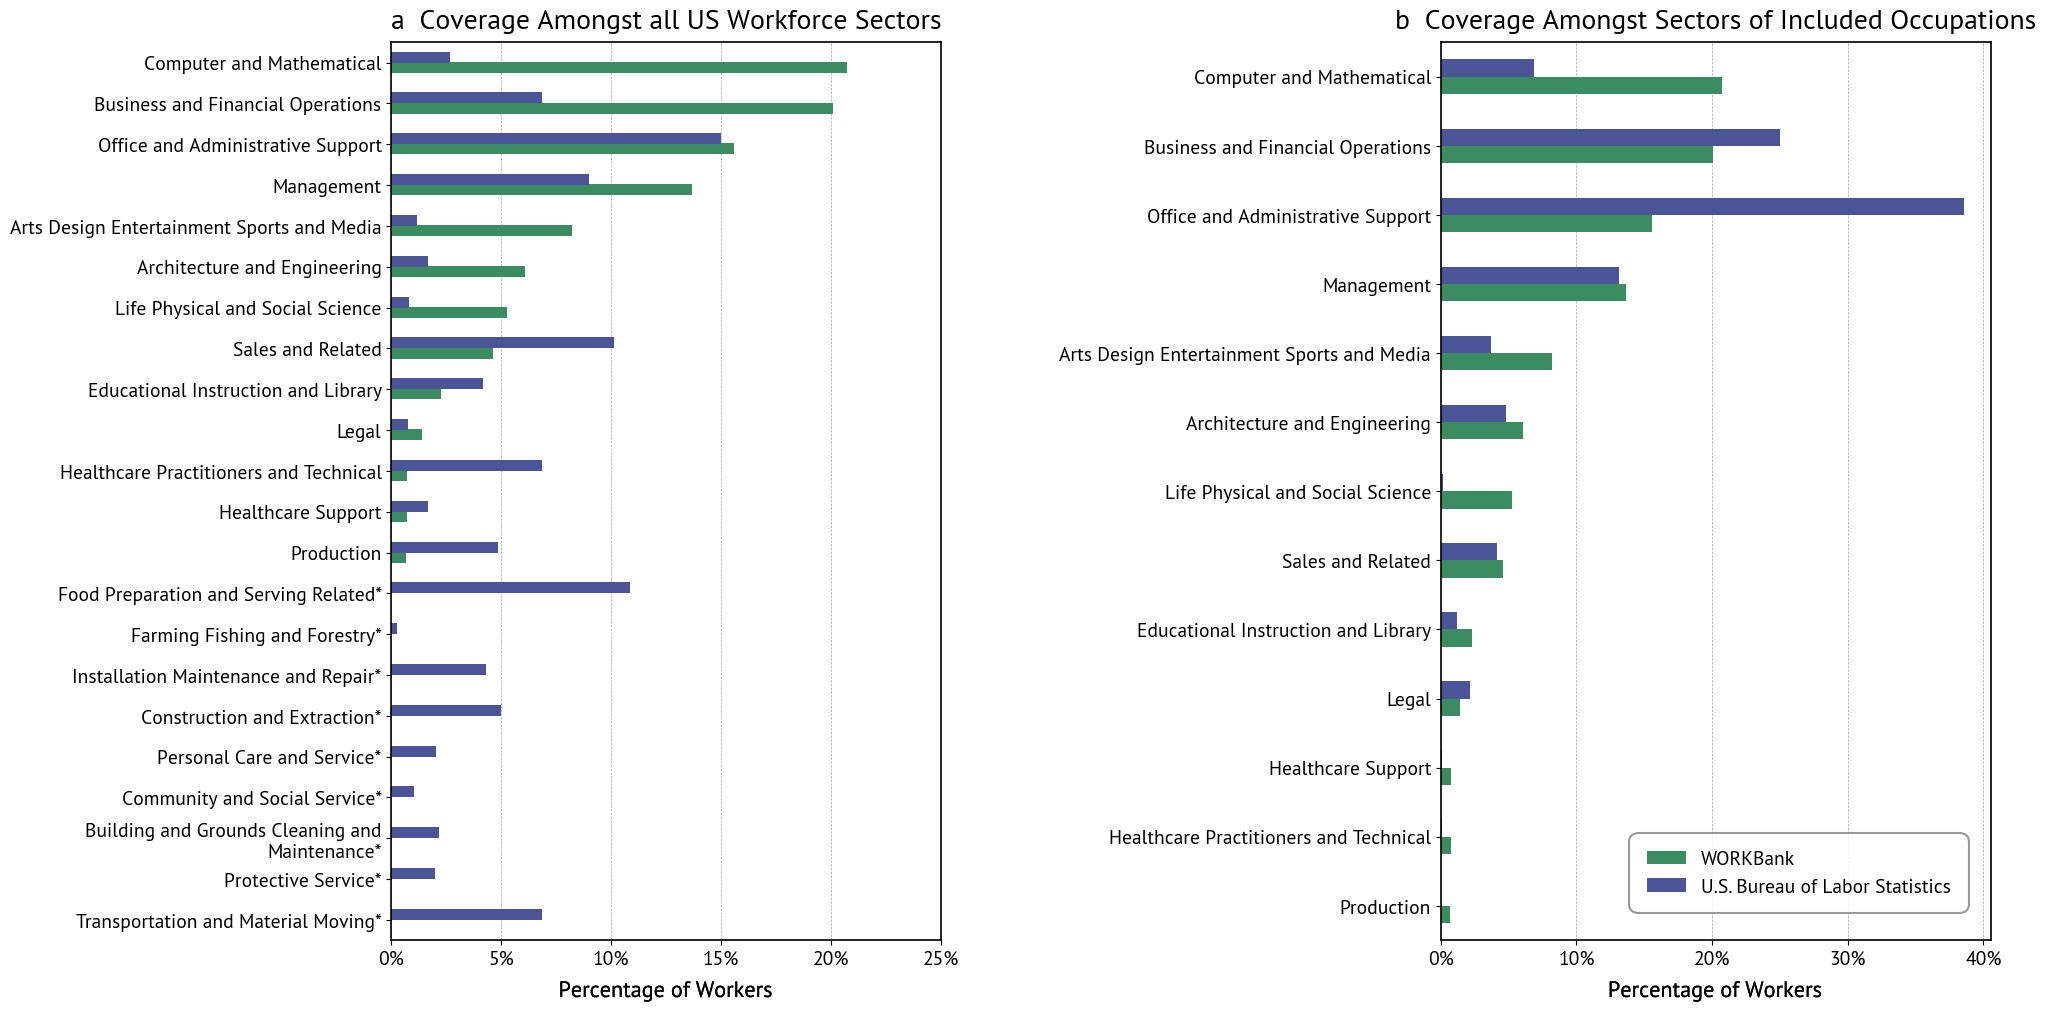

In [7]:
import matplotlib.patheffects as path_effects

def _ax_setup(ax, ylabels, title, show_ylabel=True):
    # white backgrounds
    ax.figure.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # only left & bottom spines visible
    for side in ["left", "bottom"]:
        ax.spines[side].set_color("black")
        ax.spines[side].set_linewidth(1.2)

    # grid behind bars
    ax.xaxis.grid(True, ls="--", lw=0.5, alpha=0.7, color="gray")
    ax.set_axisbelow(True)

    # labels & ticks
    label_obj = ax.set_xlabel(
        "Percentage of Workers",
        fontdict={"fontsize": 16, "fontweight":"bold"},
        labelpad=10
    )

    # Apply a stroke (outline) so it visually “thickens” the text:
    label_obj.set_path_effects([
        path_effects.withStroke(linewidth=0.1, foreground="black")
    ])

    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xticklabels(
        [f"{i}%" for i in [0, 10, 20, 30, 40]],
        fontdict={"fontsize": 14, "color": "black"},
    )

    # y-axis label
    if show_ylabel:
        ax.set_ylabel(
            "Sector",
            fontdict={"fontsize": 16, "fontweight": "bold"},
            labelpad=20
        )
    else:
        ax.set_ylabel("")  # No label

    ax.set_yticklabels(
        ylabels,
        fontdict={"fontsize": 14, "color": "black"}
    )

    # title
    ax.set_title(
        title,
        fontdict={"fontsize": 20, "fontweight": "bold"},
        pad=10
    )

    # full box outline
    for side in ["left", "right", "top", "bottom"]:
        ax.spines[side].set_color("black")
        ax.spines[side].set_linewidth(1.2)
        
domain_worker_metadata_df["Sector"] = domain_worker_metadata_df["Occupation (O*NET-SOC Title)"].map(occupation_to_sector)
bls_filtered["Sector"] = bls_filtered["OCC_TITLE"].map(occupation_to_sector)

# WORKBank: count by sector
workbank_sector_counts = domain_worker_metadata_df["Sector"].value_counts(normalize=True) * 100

# BLS: sum employment by sector for shared occupations, then normalize
bls_sector_counts = bls_filtered.groupby("Sector")["TOT_EMP"].sum()
bls_sector_percentages = (bls_sector_counts / bls_sector_counts.sum()) * 100

# Combine for comparison
sector_comparison = pd.DataFrame({
    "WORKBank": workbank_sector_counts,
    "BLS": bls_sector_percentages
}).dropna().fillna(0)

merged_all_sectors_sorted = merged_all_sectors.sort_values("WORKBank", ascending=True)

labels1 = merged_all_sectors_sorted.index.tolist()

# Append "*" to any label whose WORKBank value is exactly 0
labels1_flagged = [
    f"{label}*" if merged_all_sectors_sorted.at[label, "WORKBank"] == 0
    else label
    for label in labels1
]

sector_comparison_sorted = sector_comparison.sort_values("WORKBank", ascending=True)

# Set global font
plt.rcParams["font.family"] = "PT Sans"

wrapped_labels1 = [
    "\n".join(textwrap.wrap(label, width=45))
    for label in labels1_flagged
]
wrapped_labels2 = [
    "\n".join(textwrap.wrap(label, width=45))
    for label in sector_comparison_sorted.index
]


# Create figure with two equal‐width subplots
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(20, 10),
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.1},
    constrained_layout=True
)

# Plot 1: all workforce sectors
merged_all_sectors_sorted[["WORKBank", "BLS"]].plot(
    kind="barh",
    ax=ax1,
    color=["#3c8c61", "#4a5496"]
)
_ax_setup(ax1, wrapped_labels1, "a  Coverage Amongst all US Workforce Sectors", show_ylabel=False)

# —— 2. for plot a, restrict x-axis to 0%–25% ——
ax1.set_xlim(0, 25)
ax1.set_xticks([0, 5, 10, 15, 20, 25])
ax1.set_xticklabels(
    [f"{i}%" for i in [0, 5, 10, 15, 20, 25]],
    fontdict={"fontsize": 14, "color": "black"}
)
ax1.get_legend().remove()

# change bar width 
for bar in ax1.patches:
    bar.set_height(0.27)
    
# Plot 2: included occupations
sector_comparison_sorted.plot(
    kind="barh",
    ax=ax2,
    color=["#3c8c61", "#4a5496"],
)
_ax_setup(ax2, wrapped_labels2, "b  Coverage Amongst Sectors of Included Occupations", show_ylabel=False)


legend = ax2.legend(
    labels=["WORKBank", "U.S. Bureau of Labor Statistics"],
    loc="lower right",
    bbox_to_anchor=(0.96, 0.03),
    prop=fm.FontProperties(weight="bold", size=14),
    frameon=True
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_edgecolor("gray")
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_boxstyle("round,pad=0.5")
for text in legend.get_texts():
    text.set_fontweight("bold")

# —— 3. save as a vector PDF (no resolution issues when enlarged) ——
plt.savefig(
    "../local/sector_dist.pdf",
    format="pdf",
    bbox_inches="tight"
)

## View Demographic Distribution of WorkBANK vs. BLS Data (for covered occupations)

In [8]:
workbank_df = domain_worker_metadata_df.copy()

# ---- Step 1: Clean BLS columns ----
race_gender_bls.columns = (
    race_gender_bls.columns
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
    .str.replace("Black or African American", "Black")
    .str.replace("Hispanic or Latino", "Hispanic/Latino")
)

# ---- Step 2: Standardize column and occupation names ----
race_gender_bls["Occupation"] = race_gender_bls["Occupation"].str.strip()
workbank_df["Occupation"] = workbank_df["Occupation (O*NET-SOC Title)"].str.strip()

# ---- Step 3: Filter shared occupations ----
shared_occupations = set(race_gender_bls["Occupation"]).intersection(set(workbank_df["Occupation"]))
bls_filtered = race_gender_bls[race_gender_bls["Occupation"].isin(shared_occupations)]
workbank_filtered = workbank_df[workbank_df["Occupation"].isin(shared_occupations)]


## View Race Distribution of WORKBank vs. BLS

/var/folders/l4/hnclc8y56gxb79lptyr0msl80000gn/T/ipykernel_45599/2994254508.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workbank_filtered["Race_std"] = workbank_filtered["Race"].map(race_mapping)
/var/folders/l4/hnclc8y56gxb79lptyr0msl80000gn/T/ipykernel_45599/2994254508.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_filtered["Total employed"] = (
/var/folders/l4/hnclc8y56gxb79lptyr0msl80000gn/T/ipykernel_45599/2994254508.py:30: SettingWithCopyWarning: 
A value is trying to be set on a cop

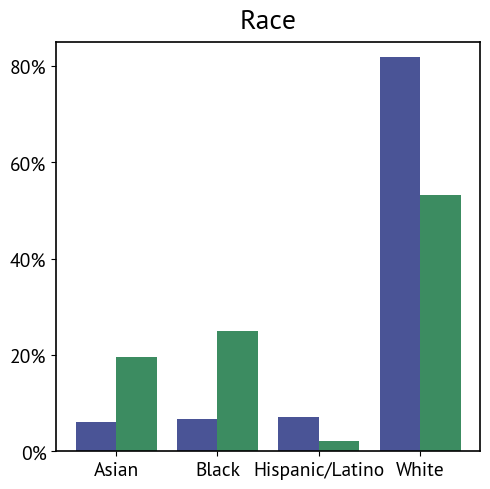

In [9]:
# ---- Step 1: Standardize race labels in WORKBank ----
race_mapping = {
    "Asian American and Pacific Islander": "Asian",
    "Black": "Black",
    "White": "White",
    "Hispanic": "Hispanic/Latino"
}
workbank_filtered["Race_std"] = workbank_filtered["Race"].map(race_mapping)

# ---- Step 2: Drop any races not reported by BLS (e.g., Native American, Other) ----
workbank_filtered = workbank_filtered[workbank_filtered["Race_std"].notnull()]

# ---- Step 3: Recalculate race distribution in WORKBank ----
race_counts = (
    workbank_filtered["Race_std"]
    .value_counts(normalize=True)
    .mul(100)
)

# ---- Step 4: Clean numeric BLS data ----
bls_filtered["Total employed"] = (
    bls_filtered["Total employed"]
    .astype(str)
    .str.replace(",", "")
    .astype(float)
)

percentage_columns = ['Women', 'White', 'Black', 'Asian', 'Hispanic/Latino']
for col in percentage_columns:
    bls_filtered[col] = pd.to_numeric(bls_filtered[col], errors="coerce")

# ---- Step 5: Calculate weighted BLS race averages for shared occupations ----
def weighted_average(column):
    return (bls_filtered[column] * bls_filtered["Total employed"]).sum() / bls_filtered["Total employed"].sum()

bls_race = {
    "White": weighted_average("White"),
    "Black": weighted_average("Black"),
    "Asian": weighted_average("Asian"),
    "Hispanic/Latino": weighted_average("Hispanic/Latino")
}

# ---- Step 6: Only keep races that exist in both datasets ----
common_races = set(bls_race.keys()).intersection(set(race_counts.index))

# ---- Step 7: Plot comparison ----
x = range(len(common_races))
common_races = sorted(common_races)  # consistent ordering

fig, ax = plt.subplots(figsize=(5, 5))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")
for side in ["left", "right", "top", "bottom"]:
    ax.spines[side].set_color("black")
    ax.spines[side].set_linewidth(1.2)

plt.bar([i - 0.2 for i in x], [bls_race[r] for r in common_races], width=0.4, label="BLS", color="#4a5496")
plt.bar([i + 0.2 for i in x], [race_counts[r] for r in common_races], width=0.4, label="WORKBank", color="#3c8c61")
plt.xticks(x, common_races, fontdict={"fontsize": 14, "color": "black"})
ax.set_ylim(0,85)
ax.set_yticks([0, 20, 40, 60, 80])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%"], fontdict={"fontsize": 14, "color": "black"})
plt.title("Race", fontdict={"fontsize": 20, "fontweight": "bold"}, pad=10)

plt.tight_layout()
plt.show()

## View Gender Distribution of WORKBank vs. BLS (for covered occupations)

/var/folders/l4/hnclc8y56gxb79lptyr0msl80000gn/T/ipykernel_45599/520638468.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_filtered["Total employed"] = (
/var/folders/l4/hnclc8y56gxb79lptyr0msl80000gn/T/ipykernel_45599/520638468.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_filtered["Women"] = pd.to_numeric(bls_filtered["Women"], errors="coerce")


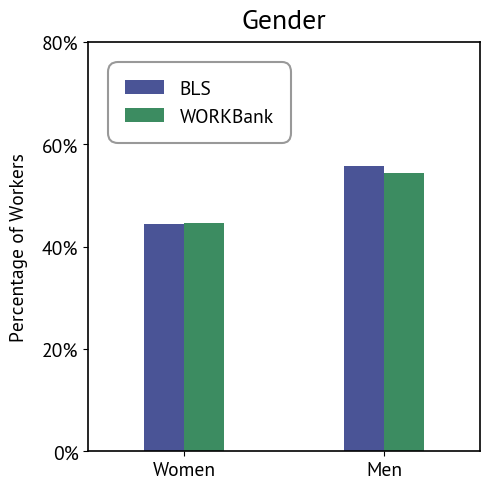

In [10]:
import numpy as np

try:
    bls_filtered.columns = (
        bls_filtered.columns
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    bls_filtered["Total employed"] = (
        bls_filtered["Total employed"]
        .astype(str)
        .str.replace(",", "")
        .astype(float)
    )
    bls_filtered["Women"] = pd.to_numeric(bls_filtered["Women"], errors="coerce")
except Exception:
    pass

women_bls = (bls_filtered["Women"] * bls_filtered["Total employed"]).sum() \
            / bls_filtered["Total employed"].sum()
men_bls   = 100 - women_bls

workbank_filtered["Gender_std"] = (
    workbank_filtered["Gender"].str.strip().str.capitalize()
)
gender_counts   = workbank_filtered["Gender_std"].value_counts(normalize=True) * 100
women_workbank  = gender_counts.get("Female", 0)
men_workbank    = gender_counts.get("Male",   0)

common_genders  = ["Women", "Men"]
bls_vals        = [women_bls,     men_bls]
wb_vals         = [women_workbank, men_workbank]


bar_w = 0.2
x_pos = np.arange(len(common_genders))

fig, ax = plt.subplots(figsize=(5, 5))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# black spines on all sides
for side in ["left", "right", "top", "bottom"]:
    ax.spines[side].set_color("black")
    ax.spines[side].set_linewidth(1.2)

# bars
ax.bar(x_pos - bar_w/2, bls_vals, width=bar_w, label="BLS",      color="#4a5496")
ax.bar(x_pos + bar_w/2, wb_vals,  width=bar_w, label="WORKBank", color="#3c8c61")

# grid / ticks
ax.grid(False)

ax.set_xticks(x_pos)
ax.set_xticklabels(common_genders, fontdict={"fontsize": 14, "color": "black"})

ax.set_ylim(0, 80)
plt.ylabel("Percentage of Workers", fontdict={"fontsize": 14, "fontweight": "bold"}, labelpad=10)
ax.set_yticks([0, 20, 40, 60, 80])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%"],
                   fontdict={"fontsize": 14, "color": "black"})


plt.title("Gender", fontdict={"fontsize": 20, "fontweight": "bold"}, pad=10)

# Style the legend
legend = ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.05, 0.95),
    prop=fm.FontProperties(weight='bold', size=14),
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_boxstyle('round,pad=0.5')
for text in legend.get_texts():
    text.set_fontweight('bold')

ax.margins(x=0.2) 
plt.tight_layout()
plt.show()


## View Age Distribution of WORKBank vs. BLS (for covered occupations)

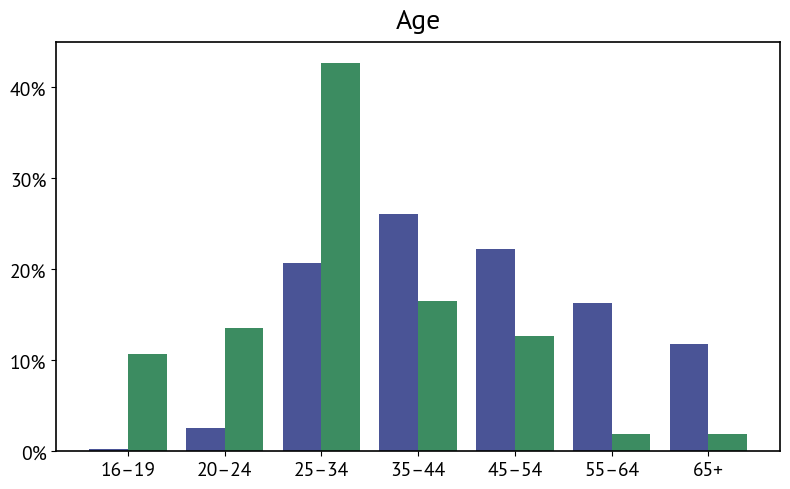

In [11]:
# Define age bins
age_bins = [16, 20, 25, 35, 45, 55, 65, 100]
age_labels = [
    "16 to 19 years", "20 to 24 years", "25 to 34 years", "35 to 44 years",
    "45 to 54 years", "55 to 64 years", "65 years and over"
]

# Clean up age_bls column names
age_bls.columns = age_bls.columns.str.replace(r'\s+', ' ', regex=True).str.strip()

# Step 1: Filter to shared occupations
bls_filtered = age_bls[age_bls["Occupation"].isin(shared_occupations)].copy()
workbank_filtered = domain_worker_metadata_df[
    domain_worker_metadata_df["Occupation (O*NET-SOC Title)"].isin(shared_occupations)
].copy()

# Step 2: Aggregate BLS counts across shared occupations
bls_age_columns = age_labels
bls_filtered = age_bls[age_bls["Occupation"].isin(shared_occupations)].copy()
bls_agg = bls_filtered[bls_age_columns].replace(",", "", regex=True).apply(pd.to_numeric).sum()
bls_age_percent = (bls_agg / bls_agg.sum()) * 100

# Step 3: Bin WORKBank ages and count
workbank_filtered["Age group"] = pd.cut(
    workbank_filtered["Age"], bins=age_bins, labels=age_labels, right=False
)
workbank_age_counts = workbank_filtered["Age group"].value_counts().sort_index()
workbank_age_percent = (workbank_age_counts / workbank_age_counts.sum()) * 100

# Step 4: Combine into a dataframe for plotting
age_comparison_df = pd.DataFrame({
    "BLS": bls_age_percent,
    "WORKBank": workbank_age_percent
})

# Step 5: Plot
common_ages = age_labels                      # already in desired order
x_pos       = np.arange(len(common_ages))     # 0-based positions
bar_w       = 0.4                             # identical bar thickness

fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# black axis lines (spines) on all four sides
for side in ["left", "right", "top", "bottom"]:
    ax.spines[side].set_color("black")
    ax.spines[side].set_linewidth(1.2)

# grouped bars
ax.bar(
    x_pos - bar_w/2,
    age_comparison_df.loc[common_ages, "BLS"],
    width=bar_w,
    label="BLS",
    color="#4a5496"
)
ax.bar(
    x_pos + bar_w/2,
    age_comparison_df.loc[common_ages, "WORKBank"],
    width=bar_w,
    label="WORKBank",
    color="#3c8c61"
)

# x-axis ticks & labels
ax.set_xticks(x_pos)
ax.set_xticklabels(
    ["16–19", "20–24", "25–34", "35–44", "45–54", "55–64", "65+"],
    fontdict={"fontsize": 14, "color": "black"}
)

# y-axis as percentages (0-80 % like your race plot)
ax.set_ylim(0, 45)
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_yticklabels(["0%", "10%", "20%", "30%", "40%"],
                   fontdict={"fontsize": 14, "color": "black"})

# title
ax.set_title("Age", fontdict={"fontsize": 20, "fontweight": "bold"}, pad=10)

plt.tight_layout()
plt.show()

## Annotation Agreement

In [16]:
import pandas as pd
import krippendorff
import numpy as np

domain_worker_desires = load_dataset("SALT-NLP/WORKBank", data_files="worker_data/domain_worker_desires.csv")["train"].to_pandas().groupby("Task")
expert_ratings = load_dataset("SALT-NLP/WORKBank", data_files="expert_ratings/expert_rated_technological_capability.csv")["train"].to_pandas().groupby("Task")

automation_desire_ratings = []
has_desire_ratings = []
for task, group in domain_worker_desires:
    ratings = group["Automation Desire Rating"].values
    if len(ratings) == 0:
        continue
    automation_desire_ratings.append(ratings)
    ratings = group["Human Agency Scale Rating"].values
    if len(ratings) == 0:
        continue
    has_desire_ratings.append(ratings)

automation_capability_ratings = []
has_capability_ratings = []
for task, group in expert_ratings:
    ratings = group["Automation Capacity Rating"].values
    if len(ratings) == 0:
        continue
    automation_capability_ratings.append(ratings)
    ratings = group["Human Agency Scale Rating"].values
    if len(ratings) == 0:
        continue
    has_capability_ratings.append(ratings)


In [17]:
def compute_krippendorff_alpha(ratings):
    """
    Compute Krippendorff's alpha for a list of ratings.
    Each case may be annotated by different numbers of annotators.
    """
    max_raters = max(len(r) for r in ratings)
    # Pad ratings to ensure all lists have the same length
    padded = []
    for r in ratings:
        r_float = np.array(r, dtype=float)
        padded_row = np.pad(r_float,
                            (0, max_raters - len(r_float)),
                            constant_values=np.nan)
        padded.append(padded_row)
    data = np.vstack(padded).T  # shape: (max_raters, num_cases)
    alpha = krippendorff.alpha(reliability_data=data, level_of_measurement='ordinal')
    
    return alpha

automation_desire_alpha = compute_krippendorff_alpha(automation_desire_ratings)
automation_capability_alpha = compute_krippendorff_alpha(automation_capability_ratings)
human_agency_desire_alpha = compute_krippendorff_alpha(has_desire_ratings)
human_agency_capability_alpha = compute_krippendorff_alpha(has_capability_ratings)
print(f"Krippendorff's alpha for Automation Desire Ratings: {automation_desire_alpha:.3f}")
print(f"Krippendorff's alpha for Automation Capability Ratings: {automation_capability_alpha:.3f}")
print(f"Krippendorff's alpha for Human Agency Scale Ratings (Desire): {human_agency_desire_alpha:.3f}")
print(f"Krippendorff's alpha for Human Agency Scale Ratings (Capability): {human_agency_capability_alpha:.3f}")

Krippendorff's alpha for Automation Desire Ratings: 0.061
Krippendorff's alpha for Automation Capability Ratings: 0.539
Krippendorff's alpha for Human Agency Scale Ratings (Desire): 0.044
Krippendorff's alpha for Human Agency Scale Ratings (Capability): 0.511


## Regression Using Mixed Effects Model

In [18]:
import pandas as pd
import statsmodels.formula.api as smf

domain_worker_desire_df = load_dataset("SALT-NLP/WORKBank", data_files="worker_data/domain_worker_desires.csv")["train"].to_pandas()
domain_worker_metadata_df = load_dataset("SALT-NLP/WORKBank", data_files="worker_data/domain_worker_metadata.csv")['train'].to_pandas()
df = (
    domain_worker_desire_df
    .merge(domain_worker_metadata_df, on=["User ID", "Occupation (O*NET-SOC Title)"])
)

def make_safe(s):
    return (s.strip().replace(' ', '_').replace('-', '_')
             .replace('(', '').replace(')', '').replace('*', '').lower())

df = df.rename(columns={col: make_safe(col) for col in df.columns})

# rename target + predictors
target = "automation_desire_rating"
categorical_features = [make_safe(c) for c in [
    'Age','Gender',
    'Education','Experience','LLM Familiarity','LLM Use in Work',
    'Race','Income','Political Affiliation',
    'LLM Usage by Type - Information Access','LLM Usage by Type - Edit',
    'LLM Usage by Type - Idea Generation','LLM Usage by Type - Communication',
    'LLM Usage by Type - Analysis','LLM Usage by Type - Decision',
    'LLM Usage by Type - Coding','LLM Usage by Type - System Design',
    'LLM Usage by Type - Data Processing',
    'AI Tedious Work Attitude',
    'AI Job Importance Attitude','AI Daily Interest Attitude','AI Suffering Attitude'
]]

df_clean = df[[target, 'task', *categorical_features]].dropna().copy()

# build & fit mixed model
formula = f"{target} ~ " + " + ".join(categorical_features)
md = smf.mixedlm(formula, df_clean, groups=df_clean["task"])
res = md.fit(method="lbfgs")
print(res.summary())

/Users/shaoyj/anaconda3/envs/agent/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


                               Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           automation_desire_rating
No. Observations:           4804              Method:                       REML                    
No. Groups:                 843               Scale:                        1.2535                  
Min. group size:            1                 Log-Likelihood:               -7581.4170              
Max. group size:            11                Converged:                    Yes                     
Mean group size:            5.7                                                                     
----------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------
Intercept             

In [19]:
var_task = res.cov_re.iloc[0, 0]
var_resid = res.scale

# compute ICC
icc = var_task / (var_task + var_resid)

print(f"Task variance: {var_task:.3f}")
print(f"Residual variance: {var_resid:.3f}")
print(f"ICC (proportion of total variance due to task): {icc:.3f}")

Task variance: 0.066
Residual variance: 1.254
ICC (proportion of total variance due to task): 0.050


## Correlation

In [21]:
from scipy.stats import spearmanr

# Automation desire vs. job loss concern
r1_s, p1_s = spearmanr(domain_worker_desire_df['Automation Desire Rating'], domain_worker_desire_df['Job Security Rating'])

# Automation desire vs. work enjoyment
r2_s, p2_s = spearmanr(domain_worker_desire_df['Automation Desire Rating'], domain_worker_desire_df['Enjoyment Rating'])

print(f"Spearman correlation between Automation Desire and Job Security: {r1_s:.3f}, p-value: {p1_s}")
print(f"Spearman correlation between Automation Desire and Enjoyment Rating: {r2_s:.3f}, p-value: {p2_s}")


Spearman correlation between Automation Desire and Job Security: -0.139, p-value: 4.863175206242197e-26
Spearman correlation between Automation Desire and Enjoyment Rating: -0.219, p-value: 2.6338477058399875e-63
